# [IUM] Predykcja czasu dostawy

## Autorzy
* Adamski Maciej
* Olga Krupa

## Zadanie


### Treść
Wygląda na to, że nasze firmy kurierskie czasami nie radzą sobie z dostawami. Gdybysmy wiedzieli, ile taka dostawa dla danego zamówienia potrwa - moglibyśmy przekazać tę informację klientom.

### Problem biznesowy
Predykcja czas dostawy zamówień - chcielibyśmy informować klientów ile będą czekać na dostarczenie przesyłki. Wynik zwrotny dla użytkownika będzie aproksymowany do pełnych godzin.

### Biznesowe kryterium sukcesu


System powinien przewidywać z większą dokładnością czas dostawy niż proste rozwiązanie oparte na wyliczeniu średniego czasu dostawy dla danego miasta.

### Analityczne kryterium sukcesu

Błąd średniokwadratowy różnicy czasów przewidywanego i rzeczywistego na zbilansowanym zbiorze testowym dla modelu zaawansowanego mniejszy niż dla modelu prostego.

<center>$ MSE_{MZ}< MSE_{MP} $</center>

<center> $ MSE(Yp, Ye) = \frac{1}{|Y|} \sum \limits _{i=1} ^{|Y|} (Yp_{i} - Ye_{i})^2 $ </center>

Gdzie:
- **$MSE$** - błąd średniokwadratowy
- **$MSE_{MZ}, MSE_{MP}$** - MSE modelu zaawansowanego i prostego
- **$Yp$** - zbiór wartości przewidywanych
- **$Ye$** - zbiór wartości oczekiwanych (rzeczywistych)
- **$|Y|$** - wielkość zbioru

### Typ zadania modelowania
Regresja/aproksymacja - przewidywanie parametrów

# Wstępna analiza

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from scipy.stats import norm
from matplotlib.pyplot import figure

In [2]:
def loadData(file_name):
    return pd.read_json("../data/raw/" + file_name, lines = True)

## Tabela *deliveries*

In [3]:
deliveries = loadData("deliveries.jsonl")

In [4]:
deliveries.count()

purchase_id           7383
purchase_timestamp    7383
delivery_timestamp    7383
delivery_company      7383
dtype: int64

Wszystkie kolumeny zawierają taką samą ilość różnych od *null* wartości. Wynika z tego, że nie brakuje w tej tabeli danych. Dodatkowo można stwierdzić, że wszystkie zamówienia zostały już dostarczone.

In [5]:
deliveries["purchase_id"].is_unique

True

### Kolumna *purchase_timestamp*

In [6]:
deliveries["purchase_timestamp"].dtype

dtype('O')

Ze wzgledu, że data jest jako obiekt string to musimy ją przekonwertować na typ datetime.

In [7]:
deliveries["purchase_timestamp"] = pd.to_datetime(deliveries["purchase_timestamp"])

In [8]:
col = deliveries["purchase_timestamp"]

In [9]:
{"min": col.min(), "max": col.max()}

{'min': Timestamp('2021-01-01 01:29:12'),
 'max': Timestamp('2021-10-27 15:26:48')}

Zamówienia były składane między *2021-01-01*, a *2021-10-27*.

<AxesSubplot:>

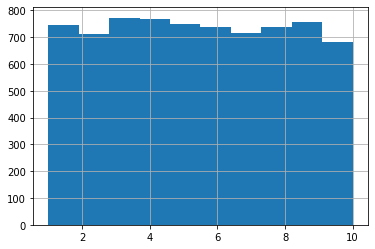

In [10]:
col.dt.month.hist()

Rozkład daty składania zamówień podzielonych na miesiące jest w przybliżeniu jednostajny.

#### Kolumna *delivery_timestamp*

In [11]:
deliveries["delivery_timestamp"].dtype

dtype('O')

In [12]:
deliveries["delivery_timestamp"] = pd.to_datetime(deliveries["delivery_timestamp"])
col = deliveries["delivery_timestamp"]

In [13]:
{"min": col.min(), "max": col.max()}

{'min': Timestamp('2021-01-02 08:09:35.963013'),
 'max': Timestamp('2021-10-30 08:44:37.680748')}

Zamówienia były dostarczone między *2021-01-02*, a *2021-10-30*.

<AxesSubplot:>

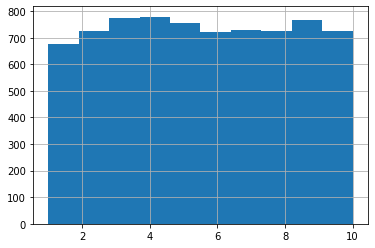

In [14]:
col.dt.month.hist()

Rozkład daty dostarczenia zamówień podzielonych na miesiące jest w przybliżeniu jednostajny.

#### Kolumna *delivery_company*

In [15]:
deliveries["delivery_company"].dtype

dtype('int64')

In [16]:
col = deliveries["delivery_company"]

In [17]:
col.unique().tolist()

[620, 360, 516]

Zamowienia dostarczone są przez trzech dostawców.

<AxesSubplot:>

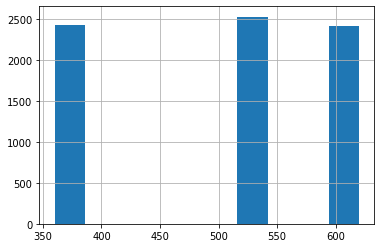

In [18]:
col.hist()

Wykorzystanie dostawców ma rozkład jednostajny.

### Czy istnieją wpisy z datą dostawy wcześniejsza niż czas zamówienia?

In [19]:
np.where((deliveries["delivery_timestamp"] < deliveries["purchase_timestamp"]))[0].size

0

Nie występują takie wpisy.

### Czas dostawy

In [20]:
deliveries["time"] = (deliveries["delivery_timestamp"] - deliveries["purchase_timestamp"]) / np.timedelta64(1,'h')

In [21]:
col = deliveries["time"]
col # czas dostawy w godzinach

0       54.442714
1       65.429676
2       58.517116
3       55.222574
4       56.719851
          ...    
7378    77.138135
7379    44.158122
7380    43.149846
7381    18.115892
7382    53.779790
Name: time, Length: 7383, dtype: float64

In [22]:
col.describe()

count    7383.000000
mean       48.001029
std        19.870723
min         4.026916
25%        33.310697
50%        47.209810
75%        61.720920
max       123.546516
Name: time, dtype: float64

Czas dostawy poszczególnych zamówień wydaje się prawidłowy - nie ma zarówno zbyt krótkich jak i zbyt długich.

In [23]:
time_mean = col.mean()
time_std = col.std()

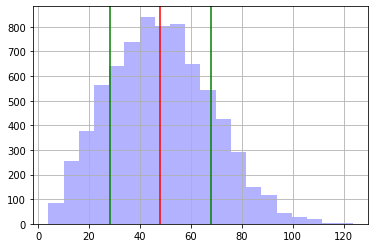

In [24]:
plt.hist(col, bins = 20, facecolor = "blue", alpha = 0.3)
plt.grid()
plt.axvline(x = time_mean, color='r')
plt.axvline(x = time_mean - time_std, color = 'g')
plt.axvline(x = time_mean + time_std, color = 'g')
plt.show()

Czas dostawy prawdopodobnie jest rozkładem normalnym $\sim N(\mu = 48.0, \sigma = 19.8)$.

## Tabela users

In [25]:
users = loadData("users.jsonl")

In [26]:
users.count()

user_id    200
name       200
city       200
street     200
dtype: int64

Nie ma żadnych pól o wartości *null*.

In [27]:
users["user_id"].is_unique

True

### Kolumna *street*

In [28]:
streetLen = set()
for row in users["street"]:
    streetLen.add(len(row.split(" ")))

streetLen

{3, 4, 5}

Pole adres składa się z 3, 4 lub 5 słów. Z 1 na przedrostek, 1/2/3 na główny człon oraz 1 na numer.

### Kolumna *city*

In [29]:
col = users["city"]

In [30]:
col.dtype

dtype('O')

In [31]:
col.unique().tolist()

['Kraków', 'Gdynia', 'Poznań', 'Szczecin', 'Radom', 'Warszawa', 'Wrocław']

Przesyłki dostarczane są do 7 różnych miast.

<AxesSubplot:>

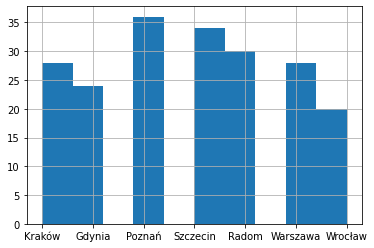

In [32]:
col.hist()

## Tabela *sessions*

In [33]:
sessions = loadData("sessions.jsonl")

In [34]:
sessions.count()

session_id          40068
timestamp           40068
user_id             40068
product_id          40068
event_type          40068
offered_discount    40068
purchase_id          7383
dtype: int64

We żadnej kolumnie poza *purchase_id* nie wystepują wartości puste. *Null* w kolumnie z id zamówienia oznacza, że podczas danej sesji klient nie złożył zamówienia. Z tego powodu nie jest to traktowane jako brak danych.

In [35]:
sessions["session_id"].is_unique

False

Brak unikalności w ID sesji wynika z faktu, że są to prawdopodobnie sesje przeglądarki i w ciągu jednej sesji użytkownik mógł oglądać i kupować różne przedmioty.

### Kolumna *timestamp*

In [36]:
sessions["timestamp"].dtype

dtype('<M8[ns]')

In [37]:
col = sessions["timestamp"]

In [38]:
{"min": col.min(), "max": col.max()}

{'min': Timestamp('2021-01-01 00:45:25'),
 'max': Timestamp('2021-10-27 15:26:48')}

Sesje występowały między *2021-01-01*, a *2021-10-27*. Przedział zgadza się z czasem zamówienia i dostawy z tabeli *deliveries*.

<AxesSubplot:>

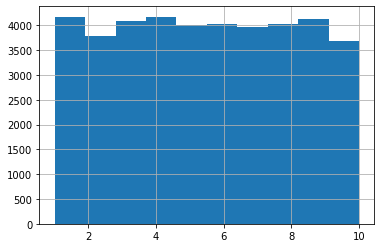

In [39]:
col.dt.month.hist()

Rozkład daty sesji podzielonych na miesiące jest w przybliżeniu jednostajny.

### Kolumna *event_type*

In [40]:
col = sessions["event_type"]

In [41]:
col.unique().tolist()

['VIEW_PRODUCT', 'BUY_PRODUCT']

<AxesSubplot:>

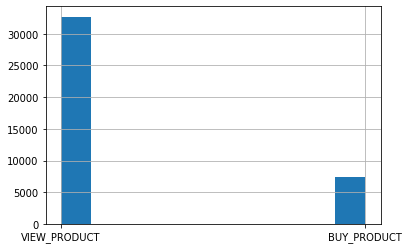

In [42]:
col.hist()

In [43]:
sessions.groupby('event_type').count()["session_id"]

event_type
BUY_PRODUCT      7383
VIEW_PRODUCT    32685
Name: session_id, dtype: int64

18.5% wszystkich sesji zakończyło się złożeniem zamówienia.

### Kolumna *offered_discount*

In [44]:
col = sessions["offered_discount"]

In [45]:
col.unique().tolist()

[0, 10, 5, 20, 15]

<AxesSubplot:>

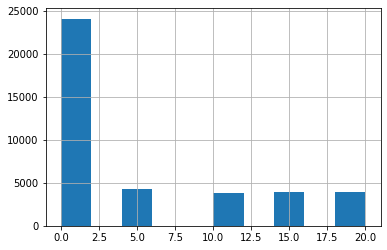

In [46]:
col.hist()

# Tabla *products*

In [47]:
products = loadData("products.jsonl")

In [48]:
products.count()

product_id       319
product_name     319
category_path    319
price            319
dtype: int64

In [49]:
products["product_id"].is_unique

True

In [50]:
products["product_name"].is_unique

True

### Kolumna *product_name*

In [51]:
products["product_name"].unique().size

319

Nazwy przedmiotów nie powtarzają się

### Kolumna *category_path*

In [52]:
categories = set()
for row in products["category_path"]:
    categories.update(row.split(';'))

In [53]:
categories

{'Akcesoria telefoniczne',
 'Anteny RTV',
 'Audio',
 'Biurowe urządzenia wielofunkcyjne',
 'Drukarki i skanery',
 'Gry PlayStation3',
 'Gry Xbox 360',
 'Gry i konsole',
 'Gry komputerowe',
 'Gry na konsole',
 'Komputery',
 'Monitory',
 'Monitory LCD',
 'Odtwarzacze DVD',
 'Odtwarzacze mp3 i mp4',
 'Okulary 3D',
 'Przenośne audio i video',
 'Sprzęt RTV',
 'Słuchawki',
 'Tablety',
 'Tablety i akcesoria',
 'Telefony i akcesoria',
 'Telefony komórkowe',
 'Telefony stacjonarne',
 'Telewizory i akcesoria',
 'Video',
 'Zestawy głośnomówiące',
 'Zestawy słuchawkowe'}

In [54]:
categories_occurence = {}
for category in categories:
    categories_occurence[category] = 0

for row in products["category_path"]:
    for category in row.split(';'):
        categories_occurence[category] += 1

categories_occurence

{'Biurowe urządzenia wielofunkcyjne': 9,
 'Audio': 1,
 'Tablety i akcesoria': 2,
 'Sprzęt RTV': 36,
 'Przenośne audio i video': 2,
 'Zestawy słuchawkowe': 4,
 'Gry komputerowe': 202,
 'Video': 33,
 'Słuchawki': 1,
 'Monitory LCD': 17,
 'Anteny RTV': 30,
 'Telefony i akcesoria': 12,
 'Akcesoria telefoniczne': 9,
 'Odtwarzacze DVD': 2,
 'Gry i konsole': 243,
 'Okulary 3D': 1,
 'Odtwarzacze mp3 i mp4': 2,
 'Gry PlayStation3': 9,
 'Zestawy głośnomówiące': 5,
 'Drukarki i skanery': 9,
 'Monitory': 17,
 'Telewizory i akcesoria': 31,
 'Gry na konsole': 41,
 'Gry Xbox 360': 32,
 'Komputery': 28,
 'Telefony stacjonarne': 1,
 'Telefony komórkowe': 2,
 'Tablety': 2}

### Kolumna *price*

In [55]:
products["price"].describe()

count     319.000000
mean      247.787962
std       813.788548
min         1.000000
25%        24.990000
50%        41.000000
75%        92.995000
max      7639.000000
Name: price, dtype: float64

Ceny ujemne należałoby traktować jako błędne dane, ale w dostarczonym zestawie nie występują.

# Analiza połączonych tabel

Jako, że tabela produktów nie przenosi dla nas żadnej potrzebnej informacji to nie zostaje dołączona.

In [56]:
joinedTables = sessions.merge(deliveries, on = "purchase_id", how = "left").merge(users, on = "user_id", how = "left")

In [57]:
joinedTables.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40068 entries, 0 to 40067
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   session_id          40068 non-null  int64         
 1   timestamp           40068 non-null  datetime64[ns]
 2   user_id             40068 non-null  int64         
 3   product_id          40068 non-null  int64         
 4   event_type          40068 non-null  object        
 5   offered_discount    40068 non-null  int64         
 6   purchase_id         7383 non-null   float64       
 7   purchase_timestamp  7383 non-null   datetime64[ns]
 8   delivery_timestamp  7383 non-null   datetime64[ns]
 9   delivery_company    7383 non-null   float64       
 10  time                7383 non-null   float64       
 11  name                40068 non-null  object        
 12  city                40068 non-null  object        
 13  street              40068 non-null  object    

## Odrzucenie niepotrzebnych danych

Możemy odrzucić wpisy, w których użytkownik tylko przeglądał produkty.

In [58]:
joinedTables = joinedTables[joinedTables["event_type"] == "BUY_PRODUCT"]
joinedTables = joinedTables.reset_index()
joinedTables.shape[0] # ilość wierszy

7383

In [59]:
joinedTables

,index,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company,time,name,city,street
0,3,124,2021-08-01 04:06:48,102,1054,BUY_PRODUCT,0,20001.0,2021-08-01 04:06:48,2021-08-03 10:33:21.769350,620.0,54.442714,Anastazja Marcińczyk,Kraków,al. Starowiejska 60
1,11,125,2021-09-01 17:03:43,102,1032,BUY_PRODUCT,10,20002.0,2021-09-01 17:03:43,2021-09-04 10:29:29.834053,360.0,65.429676,Anastazja Marcińczyk,Kraków,al. Starowiejska 60
2,13,126,2021-03-26 21:30:24,102,1035,BUY_PRODUCT,0,20003.0,2021-03-26 21:30:24,2021-03-29 08:01:25.618844,620.0,58.517116,Anastazja Marcińczyk,Kraków,al. Starowiejska 60
3,16,128,2021-06-10 05:59:29,102,1076,BUY_PRODUCT,0,20004.0,2021-06-10 05:59:29,2021-06-12 13:12:50.265103,620.0,55.222574,Anastazja Marcińczyk,Kraków,al. Starowiejska 60
4,19,129,2021-01-11 07:03:21,102,1233,BUY_PRODUCT,10,20005.0,2021-01-11 07:03:21,2021-01-13 15:46:32.464349,620.0,56.719851,Anastazja Marcińczyk,Kraków,al. Starowiejska 60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7378,40045,10591,2021-04-09 03:33:34,301,1318,BUY_PRODUCT,0,27379.0,2021-04-09 03:33:34,2021-04-12 08:41:51.284434,360.0,77.138135,Marika Grzela,Wrocław,ulica Warszawska 65
7379,40052,10594,2021-07-25 12:13:57,301,1278,BUY_PRODUCT,0,27380.0,2021-07-25 12:13:57,2021-07-27 08:23:26.240621,360.0,44.158122,Marika Grzela,Wrocław,ulica Warszawska 65
7380,40060,10597,2021-04-22 18:15:02,301,1201,BUY_PRODUCT,0,27381.0,2021-04-22 18:15:02,2021-04-24 13:24:01.447128,360.0,43.149846,Marika Grzela,Wrocław,ulica Warszawska 65
7381,40064,10599,2021-01-31 14:48:48,301,1277,BUY_PRODUCT,0,27382.0,2021-01-31 14:48:48,2021-02-01 08:55:45.211586,620.0,18.115892,Marika Grzela,Wrocław,ulica Warszawska 65


Możemy odrzucić niepotrzebne kolumny, które na pewno nie są powiązane z dostawą.

In [60]:
joinedTables.drop({"index", "session_id", "timestamp", "user_id", "product_id", "event_type", "offered_discount", "purchase_id", "name"}, axis = 1, inplace=True)
joinedTables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7383 entries, 0 to 7382
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   purchase_timestamp  7383 non-null   datetime64[ns]
 1   delivery_timestamp  7383 non-null   datetime64[ns]
 2   delivery_company    7383 non-null   float64       
 3   time                7383 non-null   float64       
 4   city                7383 non-null   object        
 5   street              7383 non-null   object        
dtypes: datetime64[ns](2), float64(2), object(2)
memory usage: 346.2+ KB


## Dodatkowe informacje o czasie dostawy

Ze względu, że dzień złożenia i dostarczenia zamówienia może mieć wpływ na czas dostawy dodajemy nową kolumnę.  
Przykładowo złożenie zamówienia w weekend opóźni czas dostawy.

In [61]:
joinedTables["purchase_day_of_week"] = joinedTables["purchase_timestamp"].dt.dayofweek
joinedTables["delivery_day_of_week"] = joinedTables["delivery_timestamp"].dt.dayofweek

In [62]:
joinedTables.groupby("purchase_day_of_week").size()

purchase_day_of_week
0    1059
1    1071
2    1074
3    1013
4    1049
5    1052
6    1065
dtype: int64

In [63]:
joinedTables.groupby("delivery_day_of_week").size()

delivery_day_of_week
0    2091
1    1052
2    1073
3    1089
4    1014
5    1064
dtype: int64

Zamówienia nie są dostarczane w niedzielę.

Podobnie postępujemy z godziną w ciągu dnia.  
Np. zamówienia złożone w godzinach wieczornych wysyłane są dopiero następnego dnia

In [64]:
joinedTables["purchase_hour"] = joinedTables["purchase_timestamp"].dt.hour
joinedTables["delivery_hour"] = joinedTables["delivery_timestamp"].dt.hour

In [65]:
joinedTables.groupby("purchase_hour").size()

purchase_hour
0     320
1     348
2     299
3     327
4     318
5     298
6     285
7     296
8     327
9     343
10    317
11    296
12    292
13    298
14    305
15    303
16    309
17    337
18    280
19    292
20    302
21    284
22    306
23    301
dtype: int64

In [66]:
joinedTables.groupby("delivery_hour").size()

delivery_hour
8     4252
9      325
10     308
11     310
12     284
13     326
14     316
15     328
16     290
17     313
18     331
dtype: int64

Zamówienia są dostarczane jedynie w godzinach 8-19.

### Średni czas dostawy do poszczególnych miast

In [67]:
cityDeliveryTime = joinedTables.groupby("city")["time"].mean()

In [68]:
{"max": cityDeliveryTime.max(), "min": cityDeliveryTime.min()}

{'max': 67.38830709965434, 'min': 33.99026069000351}

<AxesSubplot:xlabel='city'>

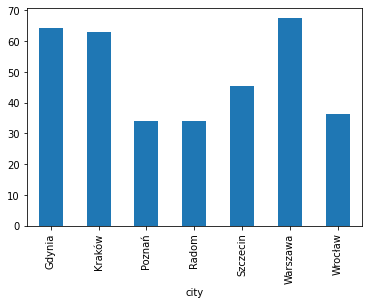

In [69]:
cityDeliveryTime.plot(kind='bar')

## Informatywność danych

In [70]:
joinedTables["city"],uniques  = pd.factorize(joinedTables["city"])
joinedTables["street"],uniques  = pd.factorize(joinedTables["street"])

In [71]:
joinedTables.drop(["purchase_timestamp", "delivery_timestamp", "delivery_day_of_week", "delivery_hour"], axis = 1, inplace = True)

In [72]:
joinedTables = joinedTables[["time", "delivery_company", "purchase_day_of_week", "purchase_hour", "city", "street"]]

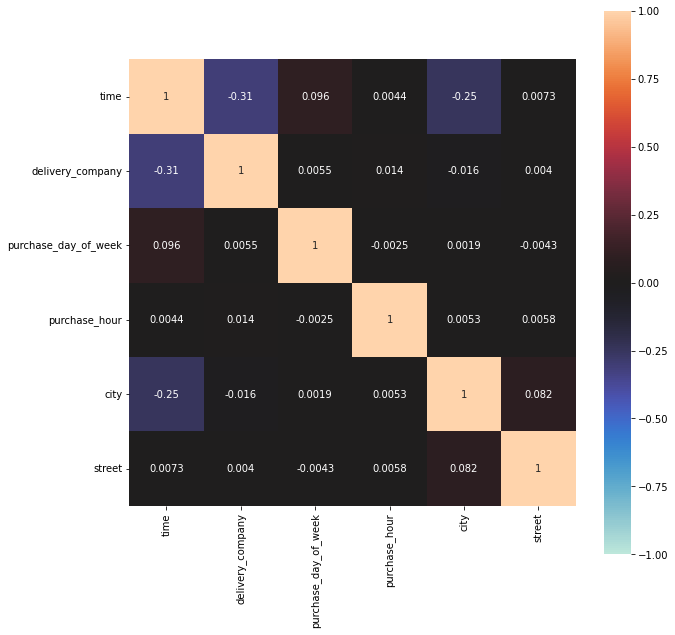

In [73]:
figure(figsize=(10, 10))

ax = sns.heatmap(
    joinedTables.corr(), 
    vmin = -1,
    vmax = 1,
    center = 0,
    square = True,
    annot = True
)

Na podstawie powyższego wykresu korelacji możemy na pewno stwierdzić, że kolumny *delivery_company* oraz *city* na pewno przenoszą informację o czasie dostawy. <br>
Mimo, że kolumny *purcahse_hour* i *purchase_day_of_week* nie osiągnęły wysokiego współczynnika korelacji to zostaną włączone do modelu, ponieważ moment zakupu wydaje się na pewno potrzebny. Na jego podstawie obliczany jest przewidwywany moment dostawy. Dodatkowo pokazane zostało wyżej, że zamówienia nie są dostarczane w niedzielę, więc *purchase_day_of_week* dla piątku czy soboty powinien wydłużyć przewidywany czas dostawy. <br>
Ze względu na niską informatywność kolumny *street* nie będzie ona istotna podczas predykcji czasu dostawy.

# Wnioski

### Jakość danych

Przeprowadzona analiza danych pokazuje, że nie występują braki, a same dane wydają się być prawidłowe. Ich ilość wstępnie można uznać za wystarczającą. Nie występują elementy, które można by uznać za odstające. Prawdopodobnie dane są zbalansowane.

### Założenia

- zamówienia są dostarczane od poniedziałku do soboty, w godzinach 8-19
- jest tylko jeden typ wysyłki
- nie ma zleceń priorytetowych
- firma korzysta z usług trzech dostawców
- maksymalna czas realizacji zamówienia to 5 dni roboczych
- wszystkie produkty są dostępne w magazynie, więc dostępność nie ma wpływu na czas dostawy
- wartość zamówienia nie wpływa na czas dostawy
- jesteśmy w stanie przewidywać czas dostawy jedynie do siedmiu miast, dla których mamy dane

### Czy potrzebny jest nowy zestaw danych?

Ze względu na dobrą jakość i wystarczającą ilość danych nie potrzebny jest nowy ich zestaw.

# Model

### Dane wejściowe

Do wytranowania modelu zostaną wykorzystane dane:
purchase_timestamp, delivery_timestamp, delivery_company oraz city. 

Do predykcji w serwisie zostaną wykorzystane dane: purchase_timestamp, delivery_company oraz city.

### Dane wyjściowe 
Wyjściem modelu będzie przewidywany czas trwania dostawy.

Informacja zwrotna przekazywana klientowi na temat terminu dostarczenia zamówienia będzie przybliżona co do dnia oraz godziny. 